In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F

from scipy import signal
from sklearn.neighbors import KernelDensity

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np

import DataSetting
import DataSetting_Cali
import PyTorch_mlp_cali_x_pre_mtl_kannsuu as torch_mlp
import Filter
import Setting_data
np.set_printoptions(threshold=np.inf)

In [2]:
M = 15

In [3]:
dir_C = "../Calibration_X/Cali_Flick"
file_Cali = "/Data"
data_F = DataSetting_Cali.re_Cali_velo(dir_C, file_Cali, 0, M, 2)


In [4]:
data_F.send_file_label

array([  10.,   10.,   10.,   10.,   10.,   20.,   20.,   20.,   20.,
         20.,   30.,   30.,   30.,   30.,   30.,   40.,   40.,   40.,
         40.,   40.,   50.,   50.,   50.,   50.,   50.,   60.,   60.,
         60.,   60.,   60.,   70.,   70.,   70.,   70.,   70.,   80.,
         80.,   80.,   80.,   80.,   90.,   90.,   90.,   90.,   90.,
        100.,  100.,  100.,  100.,  100.,  150.,  150.,  150.,  150.,
        150.,  200.,  200.,  200.,  200.,  250.,  250.,  250.,  250.,
        250.,  300.,  300.,  300.,  300.,  300.,  400.,  400.,  400.,
        400.,  400.,  500.,  500.,  500.,  500.,  500.,  600.,  600.,
        600.,  600.,  -10.,  -10.,  -10.,  -10.,  -10.,  -20.,  -20.,
        -20.,  -20.,  -20.,  -30.,  -30.,  -30.,  -30.,  -30.,  -40.,
        -40.,  -40.,  -40.,  -40.,  -50.,  -50.,  -50.,  -50.,  -50.,
        -60.,  -60.,  -60.,  -60.,  -60.,  -70.,  -70.,  -70.,  -70.,
        -70.,  -80.,  -80.,  -80.,  -80.,  -80.,  -90.,  -90.,  -90.,
        -90.,  -90.,

In [5]:

dir_C = "../Calibration_X/Cali_Track"
file_Cali = "/Data"
data_T = DataSetting_Cali.re_Cali_velo(dir_C, file_Cali, 0, M, 1)


In [6]:
dir_C = "../Calibration_X/Cali_Stop"
file_Cali = "/Data"
data_S = DataSetting_Cali.re_Cali_velo(dir_C, file_Cali, 0, M, 0)

In [7]:
data = DataSetting_Cali.Eye_Data()
data = Setting_data.ketugou_Eye_Data(data, data_F)
data = Setting_data.ketugou_Eye_Data(data, data_T)
data = Setting_data.ketugou_Eye_Data(data, data_S)
train, valid, test = Setting_data.split_gakusyuu_data(data)

In [8]:
data.send_file_label

array([  10.,   10.,   10.,   10.,   10.,   20.,   20.,   20.,   20.,
         20.,   30.,   30.,   30.,   30.,   30.,   40.,   40.,   40.,
         40.,   40.,   50.,   50.,   50.,   50.,   50.,   60.,   60.,
         60.,   60.,   60.,   70.,   70.,   70.,   70.,   70.,   80.,
         80.,   80.,   80.,   80.,   90.,   90.,   90.,   90.,   90.,
        100.,  100.,  100.,  100.,  100.,  150.,  150.,  150.,  150.,
        150.,  200.,  200.,  200.,  200.,  250.,  250.,  250.,  250.,
        250.,  300.,  300.,  300.,  300.,  300.,  400.,  400.,  400.,
        400.,  400.,  500.,  500.,  500.,  500.,  500.,  600.,  600.,
        600.,  600.,  -10.,  -10.,  -10.,  -10.,  -10.,  -20.,  -20.,
        -20.,  -20.,  -20.,  -30.,  -30.,  -30.,  -30.,  -30.,  -40.,
        -40.,  -40.,  -40.,  -40.,  -50.,  -50.,  -50.,  -50.,  -50.,
        -60.,  -60.,  -60.,  -60.,  -60.,  -70.,  -70.,  -70.,  -70.,
        -70.,  -80.,  -80.,  -80.,  -80.,  -80.,  -90.,  -90.,  -90.,
        -90.,  -90.,

In [9]:
np.unique(train.send_file_label)

array([-600., -590., -580., -575., -570., -560., -550., -550., -550.,
       -540., -530., -525., -520., -510., -500., -500., -500., -490.,
       -480., -475., -470., -460., -450., -450., -450., -440., -430.,
       -420., -410., -400., -400., -400., -400., -400., -390., -390.,
       -390., -380., -380., -380., -380., -370., -370., -370., -370.,
       -360., -360., -360., -350., -350., -350., -350., -350., -340.,
       -340., -340., -340., -330., -330., -330., -330., -320., -320.,
       -320., -310., -310., -310., -310., -300., -300., -300., -300.,
       -290., -290., -290., -290., -280., -280., -280., -280., -270.,
       -270., -270., -270., -260., -260., -260., -250., -250., -250.,
       -250., -250., -240., -240., -240., -240., -230., -230., -230.,
       -230., -220., -220., -220., -220., -210., -210., -210., -210.,
       -210., -200., -200., -200., -200., -190., -190., -190., -190.,
       -190., -190., -180., -180., -180., -180., -170., -170., -170.,
       -170., -170.,

In [10]:

x_t = train.send_v_array[:, 0, :]
y_t = train.send_y_array[:, 0, :]
w_l_t = train.send_weight[:, 0].reshape(-1, 1)
w_t = Setting_data.weight_setting(train.send_weight[:, 0], train.send_file_mode)
l_t = train.send_label[:, 0:1]
z_t = train.send_x_array[:, 0, :]
time_t = train.send_time_array

x_v = valid.send_v_array[:, 0, :]
y_v = valid.send_y_array[:, 0, :]
w_l_v = valid.send_weight[:, 0].reshape(-1, 1)
w_v = Setting_data.weight_setting(valid.send_weight[:, 0], valid.send_file_mode)
l_v = valid.send_label[:, 0:1]
z_v = valid.send_x_array[:, 0, :]
time_v = valid.send_time_array


x_test = test.send_v_array[:, 0, :]
y_test = test.send_y_array[:, 0, :]
w_l_test = test.send_weight[:, 0].reshape(-1, 1)
w_test = test.send_weight[:]
l_test = test.send_label[:, 0:1]
z_test = test.send_x_array[:, 0, :]
time_test = test.send_time_array



In [11]:
y_unique = np.unique(w_l_test)
y_unique

array([-600., -590., -580., -575., -570., -560., -550., -550., -550.,
       -550., -540., -530., -525., -510., -500., -500., -490., -480.,
       -475., -470., -460., -450., -450., -440., -430., -420., -410.,
       -400., -400., -400., -400., -390., -390., -380., -370., -370.,
       -370., -360., -360., -350., -350., -350., -340., -340., -340.,
       -330., -330., -330., -320., -320., -310., -310., -300., -300.,
       -300., -300., -300., -290., -290., -290., -280., -280., -270.,
       -270., -270., -260., -250., -250., -240., -240., -240., -230.,
       -220., -220., -220., -210., -210., -200., -200., -200., -190.,
       -190., -190., -180., -180., -170., -160., -160., -160., -150.,
       -150., -140., -140., -130., -130., -130., -120., -110., -110.,
       -100., -100., -100.,  -90.,  -90.,  -90.,  -80.,  -80.,  -70.,
        -70.,  -70.,  -70.,  -70.,  -60.,  -60.,  -50.,  -50.,  -50.,
        -50.,  -50.,  -40.,  -40.,  -40.,  -30.,  -30.,  -20.,  -20.,
        -20.,  -20.,

In [12]:
print(x_t.shape)
print(y_t.shape)
print(w_l_t.shape)
print(w_t.shape)
print(l_t.shape)
print(z_t.shape)
print(time_t.shape)

(49387, 15)
(49387, 15)
(49387, 1)
(49387, 1)
(49387, 1)
(49387, 15)
(49387, 15)


In [20]:
l_t[20000:20100]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [13]:
np.unique(l_v)

array([0., 1., 2., 3., 4., 5., 6.])

In [14]:
print(x_v.shape)

(19067, 15)


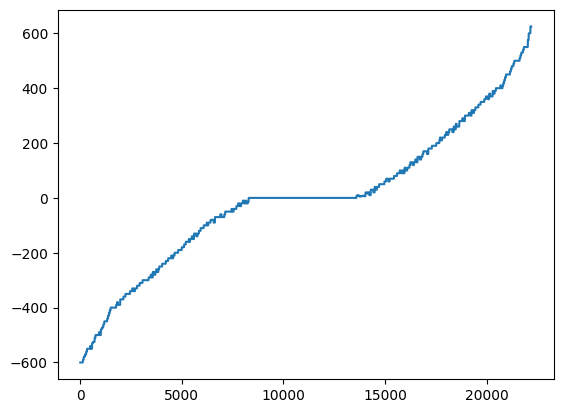

In [15]:
plt.figure()
plt.plot(w_l_test)

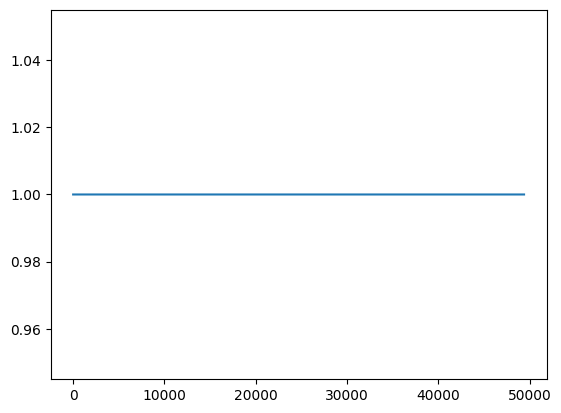

In [16]:
plt.figure()
plt.plot(w_t)

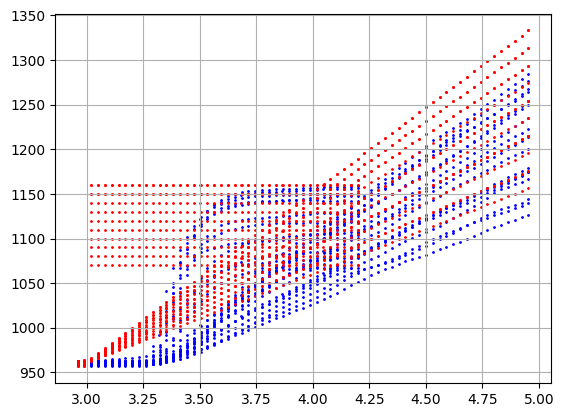

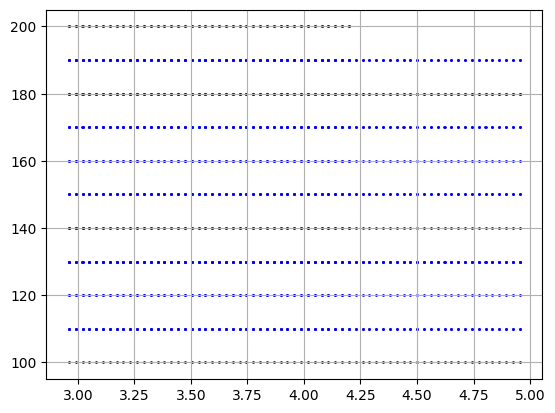

In [17]:
plt.figure()
alpha = (w_l_test[:, 0] > 100) & (w_l_test[:, 0] <=  200)
number = 0
x = time_test[alpha][:, number]
y = z_test[alpha][:, number]
plt.scatter(x, y, s = 1, c = "b")

y = (z_test[alpha] - y_test[alpha])[:, number]
plt.scatter(x, y, s = 1, c = "r")

plt.grid()

plt.figure()
x = time_test[alpha][:, 0]
y = w_test[alpha]
plt.scatter(x, y[:, number], s = 1, c = "b")
plt.grid()

In [18]:
limit_y_t = M
torch_x_t = torch.from_numpy(x_t).float().reshape(x_t.shape[0], 1, x_t.shape[1])
torch_y_t = torch.from_numpy(y_t).float()[:, :limit_y_t]
torch_w_l_t = torch.from_numpy(w_l_t).float()
torch_w_t = torch.from_numpy(w_t).float()
torch_l_t = torch.from_numpy(l_t).long()

torch_x_v = torch.from_numpy(x_v).float().reshape(x_v.shape[0], 1, x_v.shape[1])
torch_y_v = torch.from_numpy(y_v).float()[:, :limit_y_t]
torch_w_l_v = torch.from_numpy(w_l_v).float()
torch_w_v = torch.from_numpy(w_v).float()
torch_l_v = torch.from_numpy(l_v).long()

torch_x_test = torch.from_numpy(x_test).float().reshape(x_test.shape[0], 1, x_test.shape[1])
torch_y_test = torch.from_numpy(y_test).float()[:, :limit_y_t]
torch_w_l_test = torch.from_numpy(w_l_test).float()
torch_w_test = torch.from_numpy(w_test).float()
torch_l_test = torch.from_numpy(l_test).long()

print(torch_x_t.shape)
print(torch_y_t.shape)
print(torch_w_l_t.shape)
print(torch_w_t.shape)
print(torch_l_t.shape)

Dataset_t = torch.utils.data.TensorDataset(torch_x_t, torch_y_t, torch_w_l_t, torch_w_t, torch_l_t)
Dataset_v = torch.utils.data.TensorDataset(torch_x_v, torch_y_v, torch_w_l_v, torch_w_v, torch_l_v)
Dataset_test = torch.utils.data.TensorDataset(torch_x_test, torch_y_test, torch_w_l_test, torch_w_test, torch_l_test)

batch_size = 2000
train_l = torch.utils.data.DataLoader(dataset = Dataset_t, batch_size = batch_size, shuffle = True)
valid_l = torch.utils.data.DataLoader(dataset = Dataset_v, batch_size = batch_size, shuffle = True)
test_l = torch.utils.data.DataLoader(dataset = Dataset_test, batch_size = batch_size, shuffle = True)


torch.Size([49387, 1, 15])
torch.Size([49387, 15])
torch.Size([49387, 1])
torch.Size([49387, 1])
torch.Size([49387, 1])


In [17]:
class net_class (nn.Module):
    
    def __init__(self):
        super(net_class, self).__init__()
        #relu
        self.relu = nn.ReLU()
        #encoder
        self.conv1 = nn.Conv1d(1, 16, kernel_size= 5, padding=2, stride = 2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2, stride = 2)
        #bottleneck layer
        self.conv4 = nn.Conv1d(32, 32, kernel_size=5, padding=2, stride = 1)
        self.conv5 = nn.Conv1d(32, 32, kernel_size=5, padding=2, stride = 1)
        #decoder
        self.de_conv1 = nn.ConvTranspose1d(32, 16, kernel_size=5, padding=2, stride = 2)
        self.de_conv2 = nn.ConvTranspose1d(16, 1, kernel_size=7, padding=2, stride = 2)
        
    def forward(self, x):
        #encoder
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        #bottleneck layer
        x = self.conv4(x)
        x = self.relu(x)
        x = self.conv5(x)
        x = self.relu(x)
        #decoder
        x = self.de_conv1(x)
        x = self.relu(x)
        x = self.de_conv2(x)
        
        x = x.reshape(x.shape[0], -1)
        return x[:, :limit_y_t]



In [18]:
torch.autograd.set_detect_anomaly(False)
y_unique = np.unique(l_t)
print(y_unique)

net = net_class()

# criterion_1 = torch_mlp.L1Loss_weight()
criterion_1 = torch_mlp.L1Loss_weight_jyoukenn(c = 5.0, overshoot_limi=-5)

# criterion_1 = torch_mlp.Tamagawa2Loss_weight(c = 50)

optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)
# learning_class = torch_mlp.cali_x_pre_learning_hitostu_weight()


[0. 1. 2. 3. 4. 5. 6.]


In [17]:
num_epochs = 3


t_loss, t_loss_array, v_loss, v_loss_array = torch_mlp.run(net, train_l, valid_l, criterion_1, optimizer, num_epochs, 1)


epoch: 0 t_loss: 0.022463067910675004 v_loss: 0.018207550497141355
epoch: 1 t_loss: 0.014964798388064264 v_loss: 0.01493091428583889
epoch: 2 t_loss: 0.01320733870959259 v_loss: 0.01387766433358963


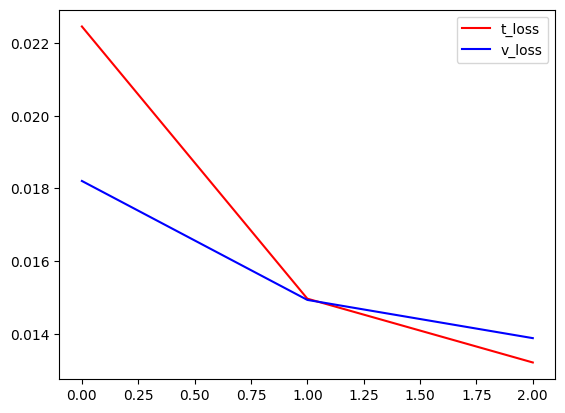

In [18]:
plt.figure()
plt.plot(range(num_epochs), t_loss, c = "r", label = "t_loss")
plt.plot(range(num_epochs), v_loss, c = "b", label = "v_loss")
plt.legend()


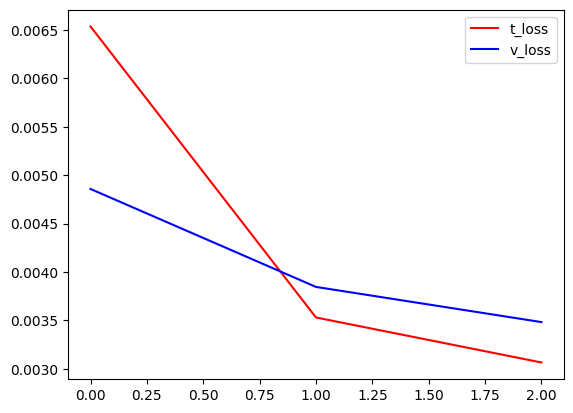

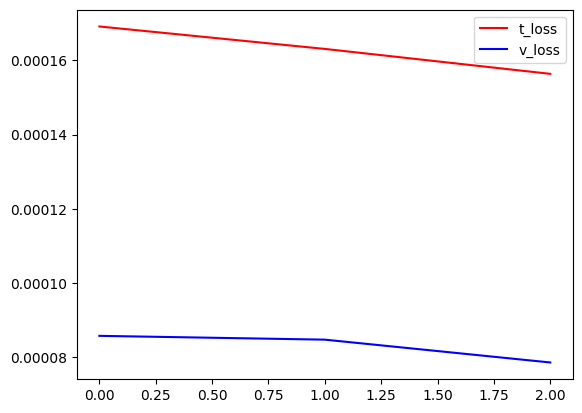

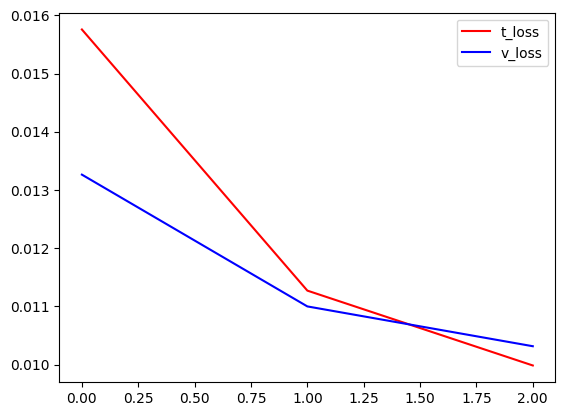

In [19]:
for i in range(len(t_loss_array)):
    plt.figure()
    plt.plot(range(num_epochs), t_loss_array[i], c = "r", label = "t_loss")
    plt.plot(range(num_epochs), v_loss_array[i], c = "b", label = "v_loss")
    plt.legend()


In [20]:
sava_path = "../model/All/l1_0.0.pth"
torch.save(net, sava_path)

(18908,)
(18908,)
(18908,)


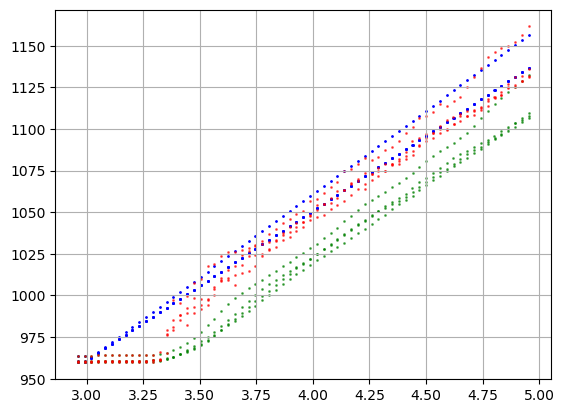

In [21]:
sava_path_ = "../model/All/l1_0.0.pth"
net_ = torch.load(sava_path_)
number = 0
y_pre = z_test[:, number] - (net_(torch_x_test)).detach().numpy().copy()[:, number]
y_answer = z_test[:, number] - y_test[:, number]
y_pre_nasi = z_test[:, number]
print(y_pre_nasi.shape)
print(y_answer.shape)
print(y_pre.shape)
plt.figure()


max_range = 100
min_range = max_range - 10
# min_range = 0
alpha = (w_l_test[:, 0] > min_range ) & (w_l_test[:, 0] <= max_range)
x = time_test[alpha][:, number]
y = y_answer[alpha]
plt.scatter(x, y, s = 1, c = "b")
y = y_pre_nasi[alpha]
plt.scatter(x, y, s = 1, c = "g", alpha=0.6)
y = y_pre[alpha]
plt.scatter(x, y, s = 1, c = "r", alpha=0.6)

plt.grid()


# plt.ylim(960 +  min_range, 960 + max_range)
# y_pre_nasi.shape

(53668,)
(53668,)
(53668,)


(53668,)

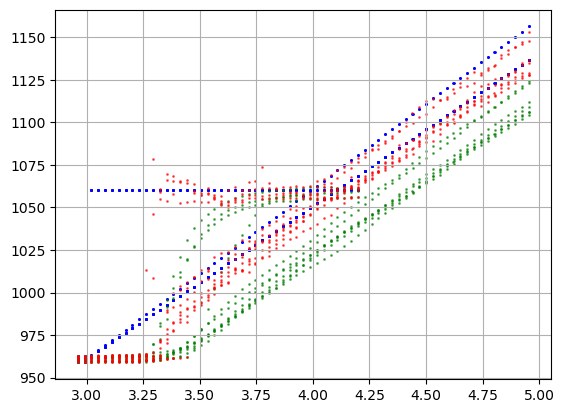

In [22]:

net_ = torch.load(sava_path_)
y_pre = z_t[:, number] - (net_(torch_x_t)).detach().numpy().copy()[:, number]
y_answer = z_t[:, number] - y_t[:, number]
y_pre_nasi = z_t[:, number]
print(y_pre_nasi.shape)
print(y_answer.shape)
print(y_pre.shape)
plt.figure()
alpha = (w_l_t[:, 0] > min_range) & (w_l_t[:, 0] <= max_range)
x = time_t[alpha][:, number]
y = y_answer[alpha]
plt.scatter(x, y, s = 1, c = "b")
y = y_pre_nasi[alpha]
plt.scatter(x, y, s = 1, c = "g", alpha=0.6)
y = y_pre[alpha]
plt.scatter(x, y, s = 1, c = "r", alpha=0.6)

plt.grid()
# plt.xlim?(3, 5)
# plt.ylim(-2, 2)
y_pre_nasi.shape

In [23]:

test = torch.arange(0, M).reshape(1, 1, -1).float()

net(test)

[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


tensor([[ 0.0424,  0.1225, -0.0060,  0.0900, -0.0552, -0.0301,  0.0721,  0.0051,
         -0.0646, -0.1315, -0.0280, -0.1269, -0.1168, -0.2032, -0.1565]],
       grad_fn=<SliceBackward0>)

In [24]:


output_conv1d = DataSetting.output_Conv1d()

conv = DataSetting.Conv1d()
conv.weight = net.conv1.weight.detach().numpy().tolist()
conv.bias = net.conv1.bias.detach().numpy().tolist()
conv.padding = net.conv1.padding[0]
conv.stride = net.conv1.stride[0]
output_conv1d.Conv1d_array.append(conv)

conv = DataSetting.Conv1d()
conv.weight = net.conv2.weight.detach().numpy().tolist()
conv.bias = net.conv2.bias.detach().numpy().tolist()
conv.padding = net.conv2.padding[0]
conv.stride = net.conv2.stride[0]
output_conv1d.Conv1d_array.append(conv)

# conv = DataSetting.Conv1d()
# conv.weight = net.conv3.weight.detach().numpy().tolist()
# conv.bias = net.conv3.bias.detach().numpy().tolist()
# conv.padding = net.conv3.padding[0]
# conv.stride = net.conv3.stride[0]
# output_conv1d.Conv1d_array.append(conv)

conv = DataSetting.Conv1d()
conv.weight = net.conv4.weight.detach().numpy().tolist()
conv.bias = net.conv4.bias.detach().numpy().tolist()
conv.padding = net.conv4.padding[0]
conv.stride = net.conv4.stride[0]
output_conv1d.Conv1d_array.append(conv)


conv = DataSetting.Conv1d()
conv.weight = net.conv5.weight.detach().numpy().tolist()
conv.bias = net.conv5.bias.detach().numpy().tolist()
conv.padding = net.conv5.padding[0]
conv.stride = net.conv5.stride[0]
output_conv1d.Conv1d_array.append(conv)


conv = DataSetting.Conv1d()
conv.weight = net.de_conv1.weight.detach().numpy().tolist()
conv.bias = net.de_conv1.bias.detach().numpy().tolist()
conv.padding = net.de_conv1.padding[0]
conv.stride = net.de_conv1.stride[0]
output_conv1d.Conv1d_array.append(conv)

conv = DataSetting.Conv1d()
conv.weight = net.de_conv2.weight.detach().numpy().tolist()
conv.bias = net.de_conv2.bias.detach().numpy().tolist()
conv.padding = net.de_conv2.padding[0]
conv.stride = net.de_conv2.stride[0]
output_conv1d.Conv1d_array.append(conv)

# conv = DataSetting.Conv1d()
# conv.weight = net.de_conv3.weight.detach().numpy().tolist()
# conv.bias = net.de_conv3.bias.detach().numpy().tolist()
# conv.padding = net.de_conv3.padding[0]
# conv.stride = net.de_conv3.stride[0]
# output_conv1d.Conv1d_array.append(conv)


dirPre = "../PyData"
filePre = "/pytorch_cali_x_pre_All"


name = dirPre + filePre
DataSetting.Pre_output(output_conv1d, name)